## Homework

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import tree, metrics, model_selection
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.pyplot as plt

In [13]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1OKFSv2GpuUFDphO0r8LdM7bl6MAWwBfX' -O data.csv

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"id" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [14]:
import wget
url = 'https://docs.google.com/uc?export=download&id=1OKFSv2GpuUFDphO0r8LdM7bl6MAWwBfX'

wget.download(url, 'data.csv')

100% [........................................................................] 33322228 / 33322228

'data (1).csv'

В этой домашней работе вы будете предсказывать стоимость домов по их характеристикам.

Метрика качества: `RMSE`

Оценивание:
* Baseline - 2 балла
* Feature Engineering - 2 балла
* Model Selection - 3 балла
* Ensemble v.1 - 3 балла
* (*) Ensemble v.2 - дополнительно, 2 балла

### Описание датасета

Короткое описание данных:
```
price: sale price (this is the target variable)
id: transaction id
timestamp: date of transaction
full_sq: total area in square meters, including loggias, balconies and other non-residential areas
life_sq: living area in square meters, excluding loggias, balconies and other non-residential areas
floor: for apartments, floor of the building
max_floor: number of floors in the building
material: wall material
build_year: year built
num_room: number of living rooms
kitch_sq: kitchen area
state: apartment condition
product_type: owner-occupier purchase or investment
sub_area: name of the district

The dataset also includes a collection of features about each property's surrounding neighbourhood, and some features that are constant across each sub area (known as a Raion). Most of the feature names are self explanatory, with the following notes. See below for a complete list.

full_all: subarea population
male_f, female_f: subarea population by gender
young_*: population younger than working age
work_*: working-age population
ekder_*: retirement-age population
n_m_{all|male|female}: population between n and m years old
build_count_*: buildings in the subarea by construction type or year
x_count_500: the number of x within 500m of the property
x_part_500: the share of x within 500m of the property
_sqm_: square meters
cafe_count_d_price_p: number of cafes within d meters of the property that have an average bill under p RUB
trc_: shopping malls
prom_: industrial zones
green_: green zones
metro_: subway
_avto_: distances by car
mkad_: Moscow Circle Auto Road
ttk_: Third Transport Ring
sadovoe_: Garden Ring
bulvar_ring_: Boulevard Ring
kremlin_: City center
zd_vokzaly_: Train station
oil_chemistry_: Dirty industry
ts_: Power plant
```

### Setup

In [2]:
df = pd.read_csv("data.csv", parse_dates=["timestamp"])
df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price
0,0,2014-12-26,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,36,7,2,15,33,1,12,75,10,15318960
1,1,2012-10-04,64,64.0,16.0,NaN,NaN,NaN,NaN,NaN,...,2,2,0,0,13,1,0,6,1,6080000
2,2,2014-02-05,83,44.0,9.0,17.0,1.0,1985.0,3.0,10.0,...,13,6,1,8,18,0,1,52,0,17000000
3,3,2012-07-26,71,49.0,2.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,3,0,2,8,2,990000
4,4,2014-10-29,60,42.0,9.0,9.0,1.0,1970.0,3.0,6.0,...,3,1,0,5,8,0,1,34,5,7900000


In [3]:
df.shape

(20000, 292)

Посмотрим какие колонки содержат пропущенные значения и долю Nan в них:

In [4]:
df.isna().sum()[df.isna().sum() !=0 ] / df.shape[0] * 100

life_sq                                  20.515
floor                                     0.565
max_floor                                31.515
material                                 31.515
build_year                               44.525
num_room                                 31.515
kitch_sq                                 31.515
state                                    44.535
preschool_quota                          21.395
school_quota                             21.385
hospital_beds_raion                      47.020
raion_build_count_with_material_info     15.875
build_count_block                        15.875
build_count_wood                         15.875
build_count_frame                        15.875
build_count_brick                        15.875
build_count_monolith                     15.875
build_count_panel                        15.875
build_count_foam                         15.875
build_count_slag                         15.875
build_count_mix                         

In [5]:
print(f'{round(df.isna().sum()[df.isna().sum() !=0 ].count() / df.shape[1] * 100, 2)}% признаков содержат Nan')

17.47% признаков содержат Nan


Заполним Nan значениями:

In [6]:
# Получаем список колонок, в которых есть Nan
nan_list = list((df.isna().sum()[df.isna().sum() !=0 ]).index)
nan_dict = {}

# Я заметил, что в колонке "год постройки" среднее значение = 3687 из-за того что некоторые значения записаны так "20052009.0"
# Поэтому именно в этой колонке я беру моду
for column in nan_list:
    if column == 'build_year':
        nan_dict[column] = df.mode()['build_year'][0]
    else:
        nan_dict[column] = df[column].median()
df = df.fillna(nan_dict)
df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price
0,0,2014-12-26,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,36,7,2,15,33,1,12,75,10,15318960
1,1,2012-10-04,64,64.0,16.0,12.0,1.0,2014.0,2.0,6.0,...,2,2,0,0,13,1,0,6,1,6080000
2,2,2014-02-05,83,44.0,9.0,17.0,1.0,1985.0,3.0,10.0,...,13,6,1,8,18,0,1,52,0,17000000
3,3,2012-07-26,71,49.0,2.0,12.0,1.0,2014.0,2.0,6.0,...,0,0,0,1,3,0,2,8,2,990000
4,4,2014-10-29,60,42.0,9.0,9.0,1.0,1970.0,3.0,6.0,...,3,1,0,5,8,0,1,34,5,7900000


Возможно в ваших моделях вам придется указывать, какие колонки являются категориальными (например, в бустингах). Для упрощения предлагается разделить колонки по следующему принципу:
```
drop_columns = [
    'id',           # May leak information
    'timestamp',    # May leak information
]
cat_columns = [
    'product_type',              #
    'material',                  # Material of the wall
    'state',                     # Satisfaction level
    'sub_area',                  # District name
    'culture_objects_top_25',    #
    'thermal_power_plant_raion', #
    'incineration_raion',        #
    'oil_chemistry_raion',       #
    'radiation_raion',           #
    'railroad_terminal_raion',   #
    'big_market_raion',          #
    'nuclear_reactor_raion',     #
    'detention_facility_raion',  #
    'ID_metro',                  #
    'ID_railroad_station_walk',  #
    'ID_railroad_station_avto',  #
    'water_1line',               #
    'ID_big_road1',              #
    'big_road1_1line',           #
    'ID_big_road2',              #
    'railroad_1line',            #
    'ID_railroad_terminal',      #
    'ID_bus_terminal',           #
    'ecology',                   #
]
num_columns = list(set(df.columns).difference(set(cat_columns + drop_columns)))
```

Преобразуем категориальные признаки:

In [7]:
cat_columns = [
    'product_type',              
    'material',                                      
    'sub_area',                  
    'culture_objects_top_25',    
    'thermal_power_plant_raion', 
    'incineration_raion',        
    'oil_chemistry_raion',       
    'radiation_raion',           
    'railroad_terminal_raion',   
    'big_market_raion',          
    'nuclear_reactor_raion',     
    'detention_facility_raion',  
    'ID_metro',                  
    'ID_railroad_station_walk',  
    'ID_railroad_station_avto',  
    'water_1line',               
    'ID_big_road1',             
    'big_road1_1line',           
    'ID_big_road2',              
    'railroad_1line',            
    'ID_railroad_terminal',     
    'ID_bus_terminal',          
    'ecology' ] 
df = pd.get_dummies(df, columns=cat_columns)
df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,build_year,num_room,kitch_sq,state,...,ID_bus_terminal_10,ID_bus_terminal_11,ID_bus_terminal_12,ID_bus_terminal_13,ID_bus_terminal_14,ecology_excellent,ecology_good,ecology_no data,ecology_poor,ecology_satisfactory
0,0,2014-12-26,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,1,0
1,1,2012-10-04,64,64.0,16.0,12.0,2014.0,2.0,6.0,2.0,...,0,0,0,0,0,0,0,1,0,0
2,2,2014-02-05,83,44.0,9.0,17.0,1985.0,3.0,10.0,3.0,...,0,0,0,0,0,0,1,0,0,0
3,3,2012-07-26,71,49.0,2.0,12.0,2014.0,2.0,6.0,2.0,...,0,0,0,0,0,0,0,1,0,0
4,4,2014-10-29,60,42.0,9.0,9.0,1970.0,3.0,6.0,2.0,...,0,0,0,0,0,0,1,0,0,0


Разделите имеющиеся у вас данные на обучающую и тестовую выборки. В качестве обучающей выборки возьмите первые 80% данных, последние 20% - тестовая выборка.

In [8]:
drop_columns = ['id','timestamp']
X = df.drop(columns=drop_columns + ['price'])
y = df['price']

# Так как train_test_split разбивает данные рандомно, я использовал срезы
length = X.shape[0]

X_train, X_test = X[:int(length*0.8+1)], X[int(length*0.8 + 1):] 
y_train, y_test =  y[:int(length*0.8+1)], y[int(length*0.8 + 1):] 

### Baseline (2 балла)

В качестве Baseline обучите `DecisionTreeRegressor` из `sklearn`.

In [9]:
clf = DecisionTreeRegressor(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [10]:
y_pred = clf.predict(X_test)

Проверьте качество на отложенной выборке.

In [11]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Среднеквадратическая ошибка (RMSE) на Baseline = {round(rmse)} рублей') 

Среднеквадратическая ошибка (RMSE) на Baseline = 3838862 рублей


### Feature Engineering (2 балла)

Часто улучшить модель можно с помощью аккуратного Feature Engineering.

Добавим в модель дополнительные признаки:
* "Как часто в этот год и этот месяц появлились объявления"
* "Как часто в этот год и эту неделю появлялись объявления"

In [12]:
month_year = (df.timestamp.dt.month + df.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df["month_year_cnt"] = month_year.map(month_year_cnt_map)

week_year = (df.timestamp.dt.weekofyear + df.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df["week_year_cnt"] = week_year.map(week_year_cnt_map)

C:\Users\alexe\AppData\Local\Temp/ipykernel_7160/1267522124.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  week_year = (df.timestamp.dt.weekofyear + df.timestamp.dt.year * 100)


Добавьте следюущие дополнительные признаки:
* Месяц (из колонки `timestamp`)
* День недели (из колонки `timestamp`)
* Отношение "этаж / максимальный этаж в здании" (колонки `floor` и `max_floor`)
* Отношение "площадь кухни / площадь квартиры" (колонки `kitchen_sq` и `full_sq`)

По желанию можно добавить и другие признаки.

In [13]:
df['month'] = df.timestamp.dt.month
df['weekday'] = df.timestamp.dt.weekday
df['year'] = df.timestamp.dt.year

''' При таком решении:
    df['floor_part'] = df['floor'] / df['max_floor']
у меня появились строчки со значением > 1 (чего быть не должно) 
из-за того что Nan в колонке floor я заменил средним значением, а max_floor у таких домов судя по всему меншье чем mean(floor)
Поэтому я решил заменить все значения > 1 медианным значением
'''
df['floor_part'] = np.where((df['floor'] / df['max_floor'] <= 1),df['floor'] / df['max_floor'] , 0.0)
df['floor_part'] = df['floor_part'].replace(to_replace=0.0 ,value=df.floor_part[df.floor_part <= 1].median())

df['kitchen_part'] = np.where((df['kitch_sq'] / df['full_sq'] <= 1), df['kitch_sq'] / df['full_sq'] , 0.0)
df['kitchen_part'] = df['kitchen_part'].replace(to_replace=0.0 ,value=df.kitchen_part[df.kitchen_part <= 1].median())

df['life_part'] = np.where((df['life_sq'] / df['full_sq'] <= 1), df['life_sq'] / df['full_sq'] , 0.0)
df['life_part'] = df['life_part'].replace(to_replace=0.0 ,value=df.life_part[df.life_part <= 1].median())

df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,build_year,num_room,kitch_sq,state,...,ecology_poor,ecology_satisfactory,month_year_cnt,week_year_cnt,month,weekday,year,floor_part,kitchen_part,life_part
0,0,2014-12-26,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1,0,1122,112,12,4,2014,1.000000,1.000000,1.000000
1,1,2012-10-04,64,64.0,16.0,12.0,2014.0,2.0,6.0,2.0,...,0,0,327,68,10,3,2012,0.470588,0.093750,1.000000
2,2,2014-02-05,83,44.0,9.0,17.0,1985.0,3.0,10.0,3.0,...,0,0,752,192,2,2,2014,0.529412,0.120482,0.530120
3,3,2012-07-26,71,49.0,2.0,12.0,2014.0,2.0,6.0,2.0,...,0,0,262,69,7,3,2012,0.166667,0.084507,0.690141
4,4,2014-10-29,60,42.0,9.0,9.0,1970.0,3.0,6.0,2.0,...,0,0,711,214,10,2,2014,1.000000,0.100000,0.700000


Разделите выборку на обучающую и тестовую еще раз (потому что дополнительные признаки созданы для исходной выборки).

In [14]:
X = df.drop(columns=drop_columns + ['price'])
y = df['price']

# Так как train_test_split разбивает данные рандомно, я использовал срезы
length = X.shape[0]

X_train, X_test = X[:int(length*0.8+1)], X[int(length*0.8 + 1):] 
y_train, y_test =  y[:int(length*0.8+1)], y[int(length*0.8 + 1):] 

### Model Selection (3 балла)

Посмотрите, какого качества можно добиться если использовать разные модели:
* `DecisionTreeRegressor` из `sklearn`
* `RandomForestRegressor` из `sklearn`
* `CatBoostRegressor`

Также вы можете попробовать линейные модели, другие бустинги (`LigthGBM` и `XGBoost`).

Почти все библиотеки поддерживают удобный способ подбора гиперпараметров: посмотрите как это делать в [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) или в [catboost](https://catboost.ai/docs/concepts/python-reference_catboostregressor_grid_search.html).

Проверяйте качество каждой модели на тестовой выборке и выберите наилучшую.

#### Результаты на трёх моделях без подбора гиперпараметров:

In [98]:
%%time

model_1 = DecisionTreeRegressor(random_state=42)
model_1.fit(X_train, y_train)
y_pred = model_1.predict(X_test)
rmse_1 = mean_squared_error(y_test, y_pred, squared=False)
print(f'Среднеквадратическая ошибка (RMSE) на DecisionTreeRegressor  = {round(rmse_1)} рублей') 

Среднеквадратическая ошибка (RMSE) на DecisionTreeRegressor  = 3746040 рублей
Wall time: 7.42 s


In [200]:
%%time

model_2 = RandomForestRegressor(random_state=42, n_estimators=100)
model_2.fit(X_train, y_train)
y_pred = model_2.predict(X_test)
rmse_2 = mean_squared_error(y_test, y_pred, squared=False)
print(f'Среднеквадратическая ошибка (RMSE) на RandomForestRegressor  = {round(rmse_2)} рублей') 

Среднеквадратическая ошибка (RMSE) на RandomForestRegressor  = 2729923 рублей
Wall time: 4min 47s


In [101]:
%%time
import catboost as cb

model_3 = cb.CatBoostRegressor(n_estimators=100, verbose=False)
model_3.fit(X_train, y_train)
y_pred = model_3.predict(X_test)
rmse_3 = mean_squared_error(y_test, y_pred, squared=False)
print(f'Среднеквадратическая ошибка (RMSE) на CatBoostRegressor  = {round(rmse_3)} рублей') 

Среднеквадратическая ошибка (RMSE) на CatBoostRegressor  = 2589153 рублей
Wall time: 4.43 s


Вывод: при одинаковом количестве итераций результат у catBoostRegressor чуть лучше чем у randomForestRegressor (и намного лучше, чем у DecisionTreeRegressor), а вот скорость выполнения намного выше.

#### Подбор гиперпараметров:

Выше можно увидеть, что один запуск RandomForestRegressor занимает примерно 4 минуты. Если подбирать на нём параметры, используя словарь описанный ниже, то уйдёт в лучшем случае столько времени:
    

(3 * 3 * 4 * 4 ) * 4 = 576 минут  

Поэтому, так как CatBoostRegressor показал лучший результат без подбора параметров, я решил использовать gridsearch только для него

In [23]:
grid = {'learning_rate': [0.03, 0.1, 0.3],
        'depth': [4, 8, 12],
        'l2_leaf_reg': [0.2, 0.5, 1, 3], 
        'n_estimators': [100, 200, 400, 600]}


In [24]:
tuning_model = cb.CatBoostRegressor(verbose=False)
grid_search_result = tuning_model.grid_search(grid,
                                       X=X,
                                       y=y,
                                       plot=True, 
                                       train_size=0.8,
                                       verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 2977373.452
bestIteration = 99


bestTest = 2691799.115
bestIteration = 99


bestTest = 2705339.503
bestIteration = 80


bestTest = 2988810.865
bestIteration = 99


bestTest = 2671329.286
bestIteration = 99


bestTest = 2723295.185
bestIteration = 99


bestTest = 2980232.857
bestIteration = 99


bestTest = 2680627.544
bestIteration = 99


bestTest = 2665551.712
bestIteration = 99


bestTest = 2987891.809
bestIteration = 99


bestTest = 2736528.708
bestIteration = 99


bestTest = 2688873.389
bestIteration = 99


bestTest = 2770268.081
bestIteration = 199


bestTest = 2614037.527
bestIteration = 199


bestTest = 2705339.503
bestIteration = 80


bestTest = 2782576.945
bestIteration = 199


bestTest = 2578254.173
bestIteration = 199


bestTest = 2696248.236
bestIteration = 173


bestTest = 2790995.005
bestIteration = 199


bestTest = 2602214.798
bestIteration = 198


bestTest = 2640085.966
bestIteration = 176


bestTest = 2794184.794
bestIteration = 199


bestTest = 2667457.521

KeyboardInterrupt: 

Мне пришлось прервать grid_search ввиду долгого перебора и сильного нагрева компьютера и я решил самостоятельно по отдельности перебрать гиперпараметры: 

In [15]:
import catboost as cb

model_3 = cb.CatBoostRegressor(n_estimators=100, verbose=False)
model_3.fit(X_train, y_train)
y_pred = model_3.predict(X_test)
rmse_3 = mean_squared_error(y_test, y_pred, squared=False)
print(f'Среднеквадратическая ошибка (RMSE) на CatBoostRegressor  = {round(rmse_3)} рублей') 

Среднеквадратическая ошибка (RMSE) на CatBoostRegressor  = 2589153 рублей


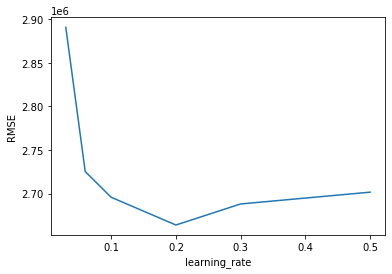

In [103]:
learning_rate_list = [0.03, 0.06, 0.1, 0.2, 0.3, 0.5]
rmse_list = []
for i in learning_rate_list:
    model = cb.CatBoostRegressor(learning_rate=i, n_estimators=100, verbose=False)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse_list.append(rmse)

plt.plot(learning_rate_list, rmse_list)
plt.xlabel('learning_rate')
plt.ylabel('RMSE')
plt.show()

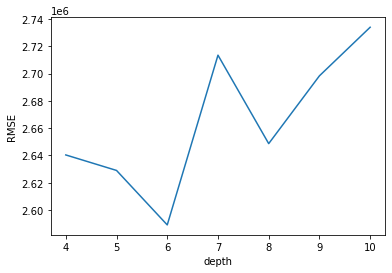

In [106]:
depth_list = [4, 5, 6, 7, 8, 9, 10]
rmse_list = []
for i in depth_list:
    model = cb.CatBoostRegressor(depth=i, n_estimators=100, verbose=False)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse_list.append(rmse)

plt.plot(depth_list, rmse_list)
plt.xlabel('depth')
plt.ylabel('RMSE')
plt.show()

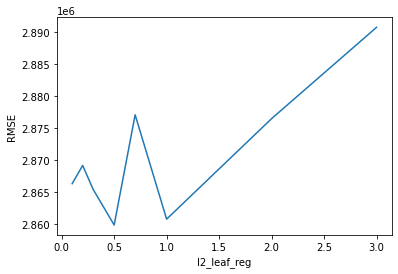

In [107]:
l2_leaf_reg_list = [0.1, 0.2, 0.3, 0.5, 0.7, 1, 2, 3]
rmse_list = []
for i in l2_leaf_reg_list:
    model = cb.CatBoostRegressor(l2_leaf_reg=i, n_estimators=100, verbose=False)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse_list.append(rmse)

plt.plot(l2_leaf_reg_list, rmse_list)
plt.xlabel('l2_leaf_reg')
plt.ylabel('RMSE')
plt.show()

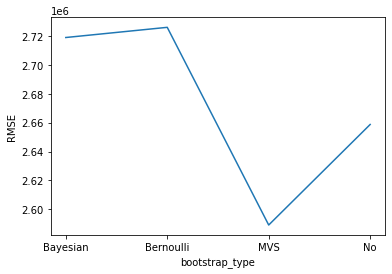

In [109]:
bootstrap_type_list = ['Bayesian' ,'Bernoulli' ,'MVS' ,'No']
rmse_list = []
for i in bootstrap_type_list:
    model = cb.CatBoostRegressor(bootstrap_type=i, n_estimators=100, verbose=False)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse_list.append(rmse)

plt.plot(bootstrap_type_list, rmse_list)
plt.xlabel('bootstrap_type')
plt.ylabel('RMSE')
plt.show()

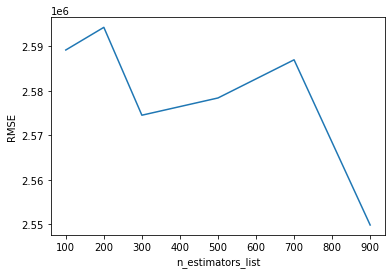

In [113]:
n_estimators_list = [100, 200, 300, 500, 700, 900]
rmse_list = []
for i in n_estimators_list:
    model = cb.CatBoostRegressor(n_estimators=i, verbose=False)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse_list.append(rmse)

plt.plot(n_estimators_list, rmse_list)
plt.xlabel('n_estimators_list')
plt.ylabel('RMSE')
plt.show()

Итоговая модель выглядит так:

In [29]:
best_model = cb.CatBoostRegressor(learning_rate=0.2, depth=6, l2_leaf_reg=0.5 ,
                                  bootstrap_type='MVS', n_estimators=900, verbose=False)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('Итоговый RMSE = ', rmse)


Итоговый RMSE =  2616026.8893902088


Данный результат показался мне немного странным: лучшие параметры (выбранные по отдельности) при одновременном использовании показывают результат, худший чем гиперпараметры по умолчанию.
Тогда лучшая модель - CatBoostRegressor со значениями по умолчанию.

### Ensemble v.1 (3 балла)

Ансамбли иногда оказываются лучше чем одна большая модель.

В колонке `product_type` содержится информация о том, каким является объявление: `Investment` (продажа квартиры как инвестиции) или `OwnerOccupier` (продажа квартиры для жилья). Логично предположить, что если сделать по модели на каждый из этих типов, то качество будет выше.

Обучите свои лучшие модели на отдельно на `Investment` и `OwnerOccupier` (т.е. у вас будет `model_invest`, обученная на `(invest_train_X, invest_train_Y)` и `model_owner`, обученная на `(owner_train_X, owner_train_Y)`) и проверьте качество на отложенной выборке (т.е. на исходном `test_split`).

Подготовка X_train и X_test:

In [16]:
invest_train_X = X_train[X_train['product_type_Investment'] == 1]
invest_train_X = invest_train_X.drop(columns=['product_type_Investment', 'product_type_OwnerOccupier'])
invest_train_X.shape

(10242, 1066)

In [17]:
invest_test_X = X_test[X_test['product_type_Investment'] == 1]
invest_test_X = invest_test_X.drop(columns=['product_type_Investment', 'product_type_OwnerOccupier'])
invest_test_X.shape

(2598, 1066)

In [18]:
owner_train_X = X_train[X_train['product_type_OwnerOccupier'] == 1]
owner_train_X = owner_train_X.drop(columns=['product_type_Investment', 'product_type_OwnerOccupier'])
owner_train_X.shape

(5759, 1066)

In [19]:
owner_test_X = X_test[X_test['product_type_OwnerOccupier'] == 1]
owner_test_X = owner_test_X.drop(columns=['product_type_Investment', 'product_type_OwnerOccupier'])
owner_test_X.shape

(1401, 1066)

Подготовка y_train:

In [20]:
invest_train_y = y_train[invest_train_X.index.to_list()]
invest_train_y.shape

(10242,)

In [21]:
owner_train_y = y_train[owner_train_X.index.to_list()]
owner_train_y.shape

(5759,)

Обучение лучшей модели на двух получившихся датасетах:

In [22]:
best_model = cb.CatBoostRegressor(n_estimators=1000, verbose=False)

In [23]:
best_model.fit(invest_train_X, invest_train_y)
y_pred_invest = best_model.predict(invest_test_X)
y_pred_invest

array([7897055.86239899, 6975031.34713086, 8343025.74728742, ...,
       6919854.21204176, 3956811.45199178, 8060332.16577709])

In [24]:
best_model.fit(owner_train_X, owner_train_y)
y_pred_owner = best_model.predict(owner_test_X)
y_pred_owner

array([ 4844466.38325593,  5686585.9396093 ,  6158591.56666871, ...,
        3333628.83535086, 12823156.81167714,  4030512.63186828])

In [26]:
# Склеиваем результаты с индексами и складываем 2 списка предсказаний

y_pred_invest = list(zip(invest_test_X.index.to_list(), y_pred_invest.tolist()))
y_pred_owner = list(zip(owner_test_X.index.to_list(), y_pred_owner.tolist()))

y_pred = y_pred_invest + y_pred_owner
len(y_pred)

3999

In [29]:
# Сортируем полученный список по индексу и оставляем только предсказания (убираем индексы)

y_pred = [x[1] for x in sorted(y_pred, key= lambda x: x[0])]

In [30]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('Итоговый RMSE = ', rmse)

Итоговый RMSE =  2575350.6943695345


RMSE на модели CatBoostRegressor без подбора параметров был равен 2589000 -> две модели на каждый из классов product_type, хоть и не на много, но улучшили результат. 

### (*) Ensemble v.2 (дополнительно, 2 балла)

Попробуйте сделать для `Investment` более сложную модель: обучите `CatBoostRegressor` и `HuberRegressor` из `sklearn`, а затем сложите их предсказания с весами `w_1` и `w_2` (выберите веса сами; сумма весов равняется 1).

In [31]:
from sklearn.linear_model import HuberRegressor

huber_model = HuberRegressor(max_iter=1000)
huber_model.fit(invest_train_X, invest_train_y)
y_pred_invest_huber = huber_model.predict(invest_test_X)
y_pred_invest_huber

C:\Users\alexe\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


array([9278851.0917542 , 8117655.15812787, 3240550.07250459, ...,
       5567858.20982641, 3994151.91982155, 7137695.20531977])

In [39]:
for i in range(1, 10):
    y_pred_invest_res = np.array([x[1] for x in y_pred_invest]) * (i/10) + np.array(y_pred_invest_huber) * (1 - i/10)
    y_pred_invest_res = list(zip(invest_test_X.index.to_list(), y_pred_invest_res.tolist()))
    y_pred = y_pred_invest_res + y_pred_owner
    y_pred = [x[1] for x in sorted(y_pred, key= lambda x: x[0])]
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f'Вес Huber Regressor = {round(1 - i/10, 2)}, Вес CatBoostRegressor = {round(i/10, 2)}, RMSE = {round(rmse)}')

Вес Huber Regressor = 0.9, Вес CatBoostRegressor = 0.1, RMSE = 3949605
Вес Huber Regressor = 0.8, Вес CatBoostRegressor = 0.2, RMSE = 3699093
Вес Huber Regressor = 0.7, Вес CatBoostRegressor = 0.3, RMSE = 3463688
Вес Huber Regressor = 0.6, Вес CatBoostRegressor = 0.4, RMSE = 3246679
Вес Huber Regressor = 0.5, Вес CatBoostRegressor = 0.5, RMSE = 3051992
Вес Huber Regressor = 0.4, Вес CatBoostRegressor = 0.6, RMSE = 2884151
Вес Huber Regressor = 0.3, Вес CatBoostRegressor = 0.7, RMSE = 2748079
Вес Huber Regressor = 0.2, Вес CatBoostRegressor = 0.8, RMSE = 2648678
Вес Huber Regressor = 0.1, Вес CatBoostRegressor = 0.9, RMSE = 2590172


По результатам видно, что чем меньше вес у HuberRegressor, тем лучше результат (то есть он, судя по всему, только мешает CatBoost)